In [11]:
# packages needed
ENV["PYTHON"]=""
using Pkg
Pkg.build("PyCall")
using Plots
pyplot()

# for input files
using MAT
using NumbersFromText
using DelimitedFiles
using CSV

# graphs/linear algebra packages
using MatrixNetworks
using SparseArrays
using LinearAlgebra

# code that I need
include("all_code/code_needed.jl")
include("all_code/methods.jl")
include("all_code/global_functions.jl")
;

  Building Conda ─→ `~/.julia/packages/Conda/CpuvI/deps/build.log`
  Building PyCall → `~/.julia/packages/PyCall/0jMpb/deps/build.log`


## Some functions that we will need

In [232]:
# just modify the trpr function slightly

function triproducts(A,x,y)
  z = similar(x)
  z .= 0
  T = triangles(A;symmetries=true)
  for tri in T
    z[tri.v1] += x[tri.v2]*y[tri.v3]
  end
  return z
end

function trpr(A, x0::Vector{Float64}, α, iter)
  normdf = zeros(iter)
  X = zeros(size(A,1),iter)
  # assumes A is a symmetric sparse matrix
  # T is a list of triangles,and fully symmetric.
  @assert(issymmetric(A))
  x = copy(x0)
  n = size(A,1)
  dg = vec(sum(A;dims=1))
  for i=1:iter
    dx = triproducts(A,x,ones(n))
    d = dx + dg
    id = map!(x -> 1.0/x, d, d)
    y = x.*id
    xn = α.*triproducts(A,x,y) + α.*(A*y) + (1-α).*x0
    normdf[i] = norm(x-xn,1)
    X[:,i] = x
    x = xn 
  end
  return x,normdf,X
end

function trpr(A, x0::Int64, α, iter)
    v = zeros(size(A,1))
    v[x0] = 1
    trpr(A,v,α,iter)
end

normdf = normdftrpr4

function plot_norms(normdf)
    p = plot(normdf,legend=false,yaxis=:log10)#,ylim=(-0.1,0.1))
    Plots.xlabel!(p,"iteration")
    Plots.ylabel!(p,"norm difference")
    Plots.scatter!(p,20:20:100,normdf[20:20:100])
    for i = 20:20:100
        Plots.annotate!(p,i+40,normdf[i],text(join(["1e",round(log10(normdf[i]),digits=1)]),11))
    end
    plot!(xtickfont=12)
    return p
end

using StatsBase
function cors_order(VV,k,iterofinterest)
#     VV = zeros(Int,size(Xs)...)
#     map(i->VV[:,i]=sortperm(Xs[:,i],rev=true),1:size(Xs,2))
    IDS = VV[1:k,:]
    dvals_S = zeros(size(Xs,2)-1)
    dvals_K = zeros(size(Xs,2)-1)
    for i = 1:size(Xs,2)-1
        dvals_S[i] = StatsBase.corspearman(IDS[:,i],IDS[:,i+1])
        dvals_K[i] = StatsBase.corkendall(IDS[:,i],IDS[:,i+1])
    end
    cor20_200_S = StatsBase.corspearman(IDS[:,iterofinterest],IDS[:,200])
    cor20_200_K = StatsBase.corkendall(IDS[:,iterofinterest],IDS[:,200])
    return dvals_S,dvals_K,cor20_200_S,cor20_200_K
end

function generate_plot_correlations(Xs)
    k = size(Xs,1)
    iterofinterest = 10
    dvals_S,dvals_K,cor20_200_S,cor20_200_K = cors_order(Xs,k,iterofinterest)
    p = plot(dvals_S,label="Spearman",linewidth=2,color=:blue,alpha=0.8,linestyle=:dot)
    plot!(dvals_K,label="Kendall",linewidth=2,color=:green,alpha=0.8,linestyle=:dash)
    plot!(legendfont=11,xtickfont=11,ytickfont=11)

    ###################################
    k = 100
    dvals_S,dvals_K,cor20_200_S,cor20_200_K = cors_order(Xs,k,iterofinterest)
    plot!(dvals_S,label="Spearman-top100",linewidth=2,color=:blue,alpha=0.8)
    plot!(dvals_K,label="Kendall-top100",linewidth=2,color=:green,alpha=0.8)
    plot!([iterofinterest,iterofinterest],[0,1],linewidth=2,color=:red,xlim = (0,30),label="")
    plot!(size=(400,400),legendfont=14,xtickfont=13,ytickfont=13,legend=:bottomright)
    

    StatsPlots.annotate!([(11,0.75,text(join(["Correlation"]),14,:left))])
    StatsPlots.annotate!([(11,0.7,text(join(["(iter",iterofinterest,",iter200)"]),14,:left))])
    StatsPlots.annotate!([(11,0.6,text(join(["Spearman = ",round(cor20_200_S,digits=2)]),14,:left))])
    StatsPlots.annotate!([(11,0.5,text(join(["Kendall = ",round(cor20_200_K,digits=2)]),14,:left))])

    return p
end
    

generate_plot_correlations (generic function with 1 method)

# TRPR convergence in norm

In [17]:
# using CSV
# M = Matrix(CSV.read("../pdatasets/PP-Pathways_ppi.csv"))
# A = sparse(M[:,1],M[:,2],1,maximum(M),maximum(M))
# A = max.(A,A')
# A = largest_component(A)[1]
# A = A-Diagonal(A)
# dropzeros!(A);
# xtrpr1,normdftrpr1,Xtrpr1 = trpr(A, 1,0.85,200);

# A = Int.(MatrixNetworks.readSMAT("../pdatasets/email.smat"))
# A = max.(A,A')
# @show issymmetric(A)
# size(A)
# A = max.(A,A');
# A = largest_component(A)[1]
# xtrpr2,normdftrpr2,Xtrpr2 = trpr(A, 1,0.85,200);

# A = Int64.(sparse(generalized_preferential_attachment_graph(600,1/2,1/2,5)));
# xtrpr3,normdftrpr3,Xtrpr3 = trpr(A, 1,0.85,200);

# T = MAT.matopen("../../fb100data/Facebook100/Penn94.mat")
# A = Int.(read(T, "A"));
# A = largest_component(A)[1]
# A = max.(A,A');
# xtrpr4,normdftrpr4,Xtrpr4 = trpr(A, 1,0.85,200);

issymmetric(A) = true


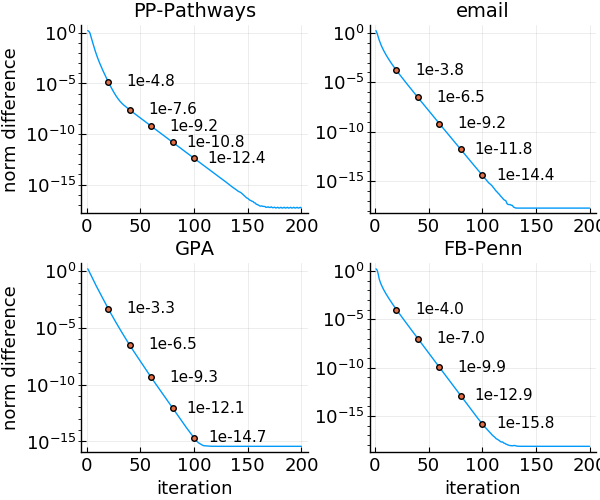

In [218]:
p1 = plot_norms(normdftrpr1)
p2 = plot_norms(normdftrpr2)
p3 = plot_norms(normdftrpr3)
p4 = plot_norms(normdftrpr4)
;
Plots.title!(p1,"PP-Pathways",xaxis = (font(5)))
plot!(p1,xlabel=nothing)
Plots.title!(p2,"email")
plot!(p2,xlabel=nothing,ylabel=nothing)
Plots.title!(p3,"GPA")
Plots.title!(p4,"FB-Penn")
plot!(p4,ylabel=nothing)
plot(p1,p2,p3,p4,layout=(2,2),size=(600,500),xaxis = (font(13)),yaxis = (font(13)))

In [219]:
savefig("trpr_convergence.pdf")

## order of vectors in TRPR are the same

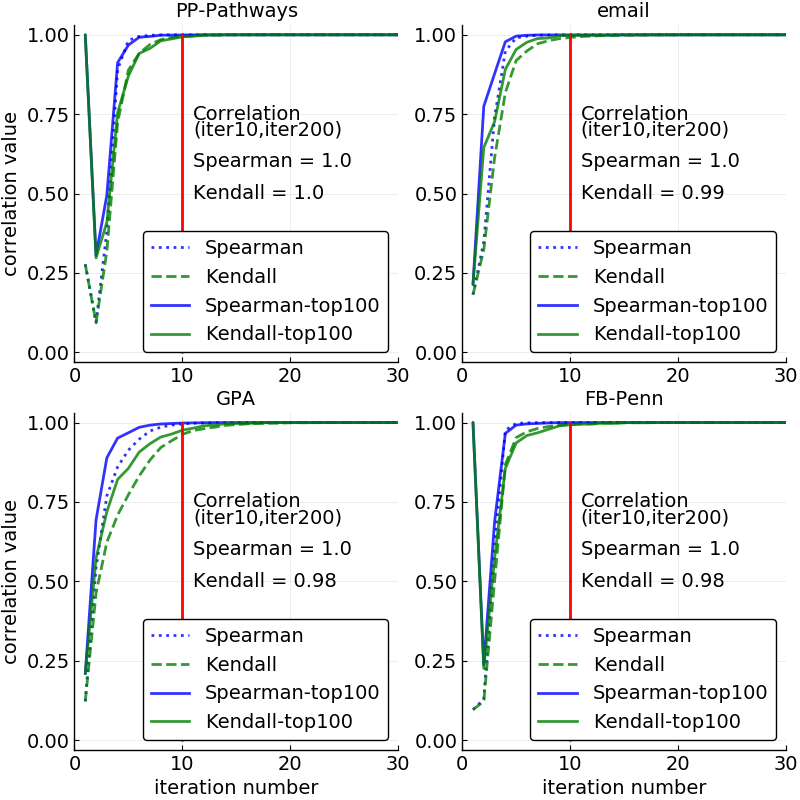

In [233]:
p1 = generate_plot_correlations(Xtrpr1)
p2 = generate_plot_correlations(Xtrpr2)
p3 = generate_plot_correlations(Xtrpr3)
p4 = generate_plot_correlations(Xtrpr4)
;

plot!(p3,xlabel="iteration number",ylabel="correlation value")
plot!(p4,xlabel="iteration number")
plot!(p1,ylabel="correlation value")

Plots.title!(p1,"PP-Pathways")
plot!(p1,xlabel=nothing)
Plots.title!(p2,"email")
plot!(p2,xlabel=nothing,ylabel=nothing)
Plots.title!(p3,"GPA")
Plots.title!(p4,"FB-Penn")
plot!(p4,ylabel=nothing)
plot(p1,p2,p3,p4,layout=(2,2),size=(800,800),xaxis=font(14),yaxis=font(14))


In [234]:
savefig("trpr_kendall_spearman.pdf")

## TRPR timing

In [172]:
nprob = collect(5:-1:1) ./ 10
eprob = 1 .- nprob
nA = [1000,2000,5000,10000,20000,50000,100000]
alltimespa = zeros(length(nA),length(nprob))

for (sizeindex,sizei) in enumerate(nA)
    for (nprobindex,nprobi) in enumerate(nprob)
        A = Int64.(sparse(generalized_preferential_attachment_graph(sizei,nprobi,1-nprobi,5)));
        trpr(A,rand(sizei),0.85,10)
        ti = @elapsed trpr(A,rand(sizei),0.85,10)
        alltimespa[sizeindex,nprobindex] = ti
    end
end
alltimespa

7×5 Array{Float64,2}:
  0.00937963   0.0123465   0.0169089   0.0182619   0.0182827
  0.0135041    0.0188661   0.0251449   0.052737    0.0521634
  0.0968289    0.0803312   0.0808143   0.10183     0.146708 
  0.116649     0.16096     0.205342    0.31375     0.354156 
  0.538433     0.625809    0.807592    1.06014     1.34668  
  4.4313       4.40934     4.88514     5.64671     6.24813  
 15.8386      16.4535     17.7549     19.7565     21.567    

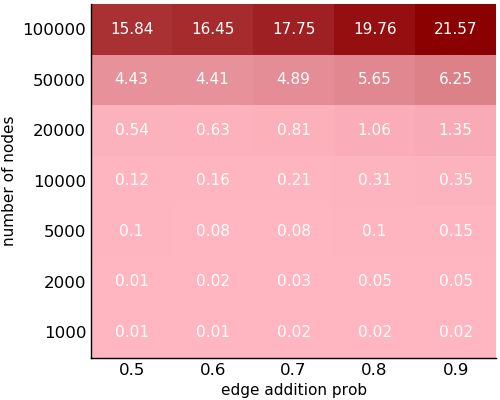

In [173]:
heatmap(alltimespa, seriescolor = :reds, 
    size = (500,400),
    yticks = (1:length(nA),nA),xtickfont=font(12),
    xticks = (1:length(eprob),eprob),ytickfont=font(12),
    xlabel = "edge addition prob",
    ylabel = "number of nodes",colorbar=false)
for i = 1:size(alltimespa,2)
    for j = 1:size(alltimespa,1)
        StatsPlots.annotate!([(i,j,text(round(alltimespa[j,i],digits=2),color=:white,11,:center))])
    end
end
plot!()

In [171]:
savefig("trpr_scalability.pdf")